# Ataque por exracción
---

#### RobertoFigueroa, Michele Benvenuto, Gustavo Méndez
Universidad Del Valle de Guatemala \
Security Data Science \
Proyecto 3 

---

Se procede a realizar ataques de extracción con el fin de replicar el comportamiento de una red preentrenada y obtener un clasificador robado con eficiencia adecuada. Para este proyecto se tomó en cuenta la librería Adversarial Robustness Toolbox https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/model-stealing-demo.ipynb

### Modelo Original

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, 
    MaxPooling2D,
    Dense,
    Rescaling,
    Flatten,
    Dropout,
    InputLayer,
    Reshape
)

from keras.models import Sequential

from sklearn.metrics import (
    confusion_matrix, 
    precision_score, 
    recall_score, 
    f1_score, 
    plot_confusion_matrix, 
    accuracy_score
)

from art.estimators.classification import KerasClassifier
from sklearn.model_selection import train_test_split
# from tensorflow.keras.optimizers import SGD


import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

In [29]:
def get_train_test(data_dir, batch_size=32, img_height=64, img_width=64):
    
    ig = tf.keras.preprocessing.image.ImageDataGenerator()
    data = ig.flow_from_directory(directory=data_dir, 
                                     target_size=(img_height, img_width), 
                                     batch_size=batch_size,
                                     seed=123)

    X, y = data.next()
    
    return X, y

In [30]:
def load_model(img_height, img_width, num_classes):
    model = Sequential([
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes)
    ])
    
    #opt = SGD(lr=0.1)
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer="adam",
                                                                  metrics=['accuracy'])
    
    return model

#### Entrenamiento Modelo Original

In [31]:
DIR = './data/malimg_paper_dataset_imgs/' 
batch_size=9339
img_height=64
img_width=64
X, y = get_train_test(DIR, batch_size, img_height, img_width)

Found 9339 images belonging to 25 classes.


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=79)

In [33]:
print("Matriz de caracteristicas para entrenamiento:\t", X_test.shape)
print("Vetor de etiquetas para entrenamiento:\t\t", y_test.shape)
print("Matriz de caracteristicas para pruebas:\t\t", X_test.shape)
print("Vetor de etiquetas para pruebas:\t\t", y_test.shape)

Matriz de caracteristicas para entrenamiento:	 (1868, 64, 64, 3)
Vetor de etiquetas para entrenamiento:		 (1868, 25)
Matriz de caracteristicas para pruebas:		 (1868, 64, 64, 3)
Vetor de etiquetas para pruebas:		 (1868, 25)


In [38]:
model = load_model(img_height, img_width, y.shape[1])

In [39]:
epochs=5
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=32
)

Train on 7471 samples
Epoch 1/5
7471/7471 [==============================] - 15s 2ms/sample - loss: 0.9526 - accuracy: 0.7066
Epoch 2/5
7471/7471 [==============================] - 15s 2ms/sample - loss: 0.1987 - accuracy: 0.9453
Epoch 3/5
7471/7471 [==============================] - 16s 2ms/sample - loss: 0.1285 - accuracy: 0.9616
Epoch 4/5
7471/7471 [==============================] - 16s 2ms/sample - loss: 0.0984 - accuracy: 0.9685
Epoch 5/5
7471/7471 [==============================] - 16s 2ms/sample - loss: 0.0745 - accuracy: 0.9758


#### Pruebas modelo original

In [40]:
print(model.evaluate(X_test, y_test))

[0.08778500176240277, 0.9641328]


### Robo de modelo

In [41]:
# Documentation: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/extraction.html#copycat-cnn
# Ref: https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/model-stealing-demo.ipynb
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets

In [42]:
num_epochs = 10
len_steal = 1600

In [43]:
og_model = KerasClassifier(model)

In [44]:
attack_catalogue = {
                    "Argmax CopycatCNN": CopycatCNN(classifier=og_model,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Argmax KnockoffNets": KnockoffNets(classifier=og_model,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                   }

In [ ]:
results = []
for len_steal in [25, 50, 200, 500, 1000, 1600]:
    indices = np.random.permutation(len(X_test))
    x_steal = X_test[indices[:len_steal]]
    y_steal = y_test[indices[:len_steal]]
    _x_test = X_test[indices[len_steal:]]
    _y_test = y_test[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = load_model(img_height, img_width, y.shape[1])
        classifier_stolen = KerasClassifier(model_stolen)
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(_x_test, _y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

Train on 25 samples
Epoch 1/10
25/25 [==============================] - 0s 5ms/sample - loss: 3.1935 - accuracy: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.6923 - accuracy: 0.2800
Epoch 3/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.5547 - accuracy: 0.2400
Epoch 4/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.4580 - accuracy: 0.1200
Epoch 5/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.3264 - accuracy: 0.2800
Epoch 6/10
25/25 [==============================] - 0s 3ms/sample - loss: 2.2858 - accuracy: 0.3200
Epoch 7/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.1917 - accuracy: 0.3600
Epoch 8/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.1137 - accuracy: 0.2800
Epoch 9/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.0521 - accuracy: 0.2400
Epoch 10/10
25/25 [==============================] - 0s 2ms/sample - loss: 1

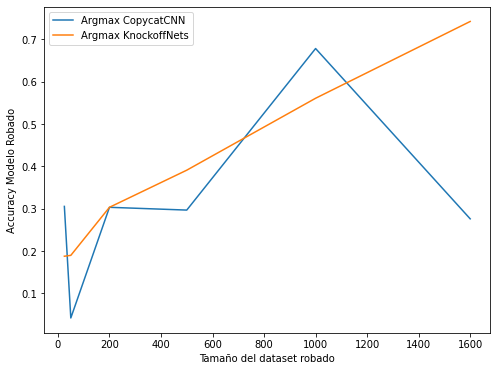

In [46]:
df = pd.DataFrame(results, columns=('Nombre del método', 'Tamaño del dataset robado', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Tamaño del dataset robado")
ax.set_ylabel("Accuracy Modelo Robado")
for name, group in df.groupby("Nombre del método"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

In [49]:
from art.defences.postprocessor import ReverseSigmoid
postprocessor = ReverseSigmoid(beta=1.0, gamma=0.2)
classifier_protected = KerasClassifier(model, postprocessing_defences=postprocessor)

In [59]:
attack_catalogue = {
                    #"Probabilistic CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                    #                          batch_size_fit=64,
                    #                          batch_size_query=64,
                    #                          nb_epochs=num_epochs,
                    #                          nb_stolen=len_steal,
                    #                          use_probability=True),
                    "Argmax CopycatCNN (vs. Protected)": CopycatCNN(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    #"Probabilistic KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                    #                          batch_size_fit=64,
                    #                          batch_size_query=64,
                    #                          nb_epochs=num_epochs,
                    #                          nb_stolen=len_steal,
                    #                          use_probability=True),
                    "Argmax KnockoffNets (vs. Protected)": KnockoffNets(classifier=classifier_protected,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
#                     "FunctionallyEquivalentExtraction": FunctionallyEquivalentExtraction(classifier=classifier_flat_protected,
#                                               num_neurons=128),  # This one takes too long time for this dataset/model.
                    }

In [60]:
results_protected = []
for len_steal in [25, 50, 200, 500, 1000, 1600]:
    indices = np.random.permutation(len(X_test))
    x_steal = X_test[indices[:len_steal]]
    y_steal = y_test[indices[:len_steal]]
    _x_test = X_test[indices[len_steal:]]
    _y_test = y_test[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = load_model(img_height, img_width, y.shape[1])
        classifier_stolen = KerasClassifier(model_stolen)
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(_x_test, _y_test)[1]
        print(name, ":", acc)
        results_protected.append((name, len_steal, acc))

Train on 25 samples
Epoch 1/10
25/25 [==============================] - 1s 30ms/sample - loss: 3.3038 - accuracy: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.7506 - accuracy: 0.4000
Epoch 3/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.2263 - accuracy: 0.2400
Epoch 4/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.8597 - accuracy: 0.1200
Epoch 5/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.1951 - accuracy: 0.1200
Epoch 6/10
25/25 [==============================] - 0s 2ms/sample - loss: 1.9392 - accuracy: 0.3200
Epoch 7/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.8139 - accuracy: 0.1200
Epoch 8/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.5622 - accuracy: 0.3600
Epoch 9/10
25/25 [==============================] - 0s 2ms/sample - loss: 2.0851 - accuracy: 0.3600
Epoch 10/10
25/25 [==============================] - 0s 2ms/sample - loss: 

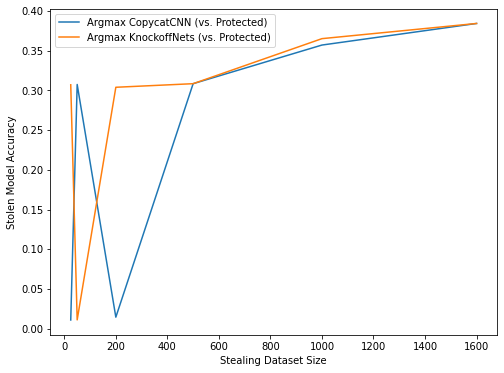

In [61]:
df_protected = pd.DataFrame(results_protected, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df_protected.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
plt.show()

### Discusión

Según Hailon y Jun (2021) el rendimiento de los modelos de extracción suele atenuarse si los adversarios obtienen la distribución parcial o distorcionada de la data generada. Para ello existen dos tipos de defensa basada en perturbación:

- **De entrada:** Incluye interpolación lineal o semántica de la entrada 
- **De salida:** Incluye ruido, ejemplos adversariales con ruido, perturbación de filtro o de compresión.


Se puede observar que el modelo robado a través de CopyCat o KnockOffCNN sobre un modelo protegido tuvo un menor redimiento a diferencia del modelo robado obtenido a través de un modelo desprotegido. Para proteger al modelo se utilizó una capa extra de postprocesamiento. Esta capa consiste en una función inversa sigmoide que permite agregar ruido o perturbación a la salida del clasificador.

### Conclusiones

   - Se logró simular un ataque de extracción que consistió en recolectar un dataset con etiquetas robadas para el posterior entrenamiento por medio de CopyCatCNN y KnockOffNets de dos modelos clasificadores.
   - Se logró proteger el modelo por medio de perturbación de salida a través de una capa consistía en una función sigmoide inversa.
   - Se logró afianzar los conocimientos aprendidos en clase sobre las vulnerabilidades y tipos de ataques que puedan llegar a tener los modelos de clasificación (para este caso, un modelo de caja negra).


### Referencias

        Hailong H., Jun P.. 2021. Stealing Machine Learning Models: Attacks and Countermeasures for Generative Adversarial Networks. In Annual Computer Security Applications Conference (ACSAC). Association for Computing Machinery, New York, NY, USA, 1–16. https://doi.org/10.1145/3485832.3485838

        Correia-Silva, J. R., Berriel, R. F., Badue, C., de Souza, A. F., & Oliveira-Santos, T. (2021). Copycat CNN: Are random non-Labeled data enough to steal knowledge from black-box models? Pattern Recognition, 113, 107830. https://doi.org/10.1016/j.patcog.2021.107830

        Tribhuvanesh, O., Schiele, B., & Fritz, M. (2018). Knockoff Nets: Stealing Functionality of Black-Box Models. Max Planck Institute for Informatics. https://arxiv.org/pdf/1812.02766.pdf
    